# Analysis of adult census data

In this notebook, I present some analysis of the adult census income date. More details on this dataset can be found here: https://www.kaggle.com/uciml/adult-census-income. The goal of the analysis is to compare different models, that predict if a person earns more than 50k (USD per year) or less. The models are built using different algorithms and different parameters.

## Importing libraries

In [167]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

## Data processing

In [168]:
# downloading the data
url1 = "https://raw.githubusercontent.com/skfp/income_analysis/main/test_data.csv"
url2 = "https://raw.githubusercontent.com/skfp/income_analysis/main/train_data.csv"
d1 = pd.read_csv(url1, sep=",", header=None)
d2 = pd.read_csv(url2, sep=",", header=None)
income_data = pd.concat([d1, d2])

In [169]:
# renaming the columns
columns_names_dict = {
    0: "id",
    1: "employment_sector",
    2: "fnlwgt",
    3: "edu",
    4: "edu-num",
    5: "marital_status",
    6: "occupation",
    7: "relation",
    8: "race",
    9: "sex",
    10: "cap-gain",
    11: "cap-loss",
    12: "hours",
    13: "country",
    14: "income"
}
income_data = income_data.rename(columns = columns_names_dict)
# dropping columns with redundant information
income_data = income_data.drop(['id', 'fnlwgt'], axis = 1)

`1.` quantitative (numerical) variables: 
* edu-num,
* cap-gain,
* cap-loss,
* hours

`2.` qualitative (categorical) variables:
* employment_sector,
* edu,
* marital_status,
* occupation relation,
* race,
* sex,
* country

`3.` label:
* income

In [170]:
# bundling some of the categorical variables
# also replacing values in binary columns "sex" and "income" by 0 and 1
edu_replace_dict = {
    "Preschool":"None",
    "1st-4th":"None",
    "5th-6th":"None",
    "7th-8th":"None",
    "9th":"None",
    "10th":"None",
    "11th":"None",
    "12th":"None",
    "Assoc-acdm":"Associates",
    "Assoc-voc":"Associates",
    "HS-grad":"HS-graduate",
    "Some-college":"HS-graduate"
}
empl_replace_dict = {
    "Without-pay":"No-Income",
    "Never-worked":"No-Income", 
    "Local-gov":"Gov",
    "State-gov":"Gov",
    "Federal-gov":"Gov",
    "Self-emp-inc":"Self-employed",
    "Self-emp-not-inc":"Self-employed"
}
sex_replace_dict = {
    "Male":1,
    "Female":0
}
income_replace_dict = {
    "<=50K.":0,
    "<=50K":0,
    ">50K.":1,
    ">50K":1,
}
country_replace_dict = {
    "South":"NE-Asia",
    "Cambodia":"SE-Asia",
    "Canada":"British-Commonwealth",
    "China":"China",
    "Columbia":"South-America",
    "Cuba":"Other",
    "Dominican-Republic":"Latin-America",
    "Ecuador":"South-America",
    "El-Salvador":"South-America",
    "England":"British-Commonwealth",
    "France":"Euro_1",
    "Germany":"Euro_1",
    "Greece":"Euro_2",
    "Guatemala":"Latin-America",
    "Haiti":"Latin-America",
    "Holand-Netherlands":"Euro_1",
    "Honduras":"Latin-America",
    "Hong":"British-Commonwealth",
    "Hungary":"Euro_2",
    "India":"British-Commonwealth",
    "Iran":"Other",
    "Ireland":"British-Commonwealth",
    "Italy":"Euro_1",
    "Jamaica":"Latin-America",
    "Japan":"NE-Asia",
    "Laos":"SE-Asia",
    "Mexico":"Latin-America",
    "Nicaragua":"Latin-America",
    "Outlying-US(Guam-USVI-etc)":"Latin-America",
    "Peru":"South-America",
    "Philippines":"SE-Asia",
    "Poland":"Euro_2",
    "Portugal":"Euro_2",
    "Puerto-Rico":"Latin-America",
    "Scotland":"British-Commonwealth",
    "Taiwan":"China",
    "Thailand":"SE-Asia",
    "Trinadad&Tobago":"Latin-America",
    "United-States":"United-States",
    "Vietnam":"SE-Asia",
    "Yugoslavia":"Euro_2"
}
occup_replace_dict = {
    "Adm-clerical":'White-Collar',
    "Craft-repair":'Blue-Collar',
    'Exec-managerial':'White-Collar',
    'Farming-fishing':'Blue-Collar',
    'Handlers-cleaners':'Blue-Collar',
    'Machine-op-inspct':'Blue-Collar',
    'Other-service':'Service', 
    'Priv-house-serv':'Service',
    'Prof-specialty':'Professional',
    'Protective-serv':'Service',
    'Tech-support':'Service',
    'Transport-moving':'Blue-Collar',
    'Unknown':'Other/Unknown',
    'Armed-Forces':'Other/Unknown',
    '?':'Other/Unknown'
}
marital_replace_dict = {
    "Divorced":"Not-married",
    "Married-AF-spouse":"Married-absent",
    "Married-civ-spouse":"Married",
    "Married-spouse-absent":"Married-absent",
    "Never-married":"Not-married",
    "Separated":"Not-married",
    "Widowed":"Not-married",
}

In [171]:
income_data["edu_agg"] = income_data["edu"].replace(edu_replace_dict)
income_data["sex"] = income_data["sex"].replace(sex_replace_dict) 
income_data["country_agg"] = income_data["country"].replace(country_replace_dict) 
income_data["empl_agg"] = income_data["employment_sector"].replace(empl_replace_dict)
income_data["occup_agg"] = income_data["occupation"].replace(occup_replace_dict)
income_data["income"] = income_data["income"].replace(income_replace_dict)
income_data["marital_agg"] = income_data["marital_status"].replace(marital_replace_dict)

In [172]:
# reseting index to avoid repeating values of index
income_data = income_data.reset_index().drop('index', axis = 1)

In [173]:
# transform data using one-hot encoding for 6 categorical variables
income_data = income_data.join(pd.get_dummies(income_data.occup_agg, prefix='occup'))
income_data = income_data.join(pd.get_dummies(income_data.empl_agg, prefix='empl'))
income_data = income_data.join(pd.get_dummies(income_data.country_agg, prefix='country'))
income_data = income_data.join(pd.get_dummies(income_data.marital_agg, prefix='marital'))

income_data = income_data.join(pd.get_dummies(income_data.race, prefix='race'))
income_data = income_data.join(pd.get_dummies(income_data.relation, prefix='relation'))

## k nearest neighbours algorithm

In [174]:
# excluding from the model columns with categorical values
exclude_cols = ['employment_sector', 'edu', 'marital_status', 'occupation', 'relation', 'race', 'country',
                'edu_agg', 'country_agg', 'empl_agg', 'occup_agg', 'marital_agg', 'income']
knn_cols = [c for c in income_data.columns if c not in exclude_cols]
# splitting dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(income_data[knn_cols], income_data.income, test_size=0.2)

In [175]:
k_values = [2,3,4,5,7,10,15,20,30,50]
acc_values = []

# checking the accuracy of the models with different numbers of k parameter with 4-fold CV
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = cross_val_score(knn, X_train, y_train, cv = 4)
    acc = np.mean(scores)
    acc_values.append(acc)

In [176]:
for i in range(len(k_values)):
    print("k: %i,   Accuracy: %0.4f" % (k_values[i], acc_values[i]))

k: 2,   Accuracy: 0.8427
k: 3,   Accuracy: 0.8444
k: 4,   Accuracy: 0.8519
k: 5,   Accuracy: 0.8538
k: 7,   Accuracy: 0.8568
k: 10,   Accuracy: 0.8585
k: 15,   Accuracy: 0.8594
k: 20,   Accuracy: 0.8608
k: 30,   Accuracy: 0.8593
k: 50,   Accuracy: 0.8566


In [177]:
# testing the model with the k parameter chosen with CV
knn_clf = KNeighborsClassifier(n_neighbors = 20)

knn_clf.fit(X_train, y_train)
y_pred = knn_clf.predict(X_test)

print("Accuracy: %0.4f" % metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8571


In [178]:
print("Precision: %0.4f" % metrics.precision_score(y_test, y_pred))
print("Recall:    %0.4f" % metrics.recall_score(y_test, y_pred))
print("AUC:       %0.4f" % metrics.roc_auc_score(y_test, y_pred))
print("F1:        %0.4f" % metrics.f1_score(y_test, y_pred))

Precision: 0.7785
Recall:    0.5706
AUC:       0.7594
F1:        0.6585


In [179]:
knn_metrics = [metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
              metrics.recall_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred),
              metrics.f1_score(y_test, y_pred)]

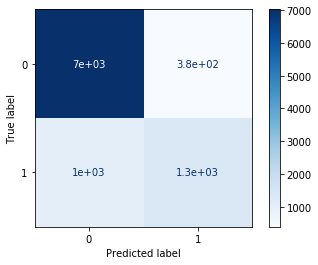

In [180]:
metrics.plot_confusion_matrix(knn_clf, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.show()

## Decision tree

In [181]:
dt_clf = DecisionTreeClassifier(random_state = 1)
cvs = cross_val_score(dt_clf,X_train,y_train,cv=4)
print(cvs)
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))

[0.84041355 0.84531122 0.84203522 0.83906634]
Accuracy: 0.8417 (+/- 0.0047)


In [182]:
depths_list = [3, 4, 5, 7, 10, 15, 20, 40]
acc_values = []
for depth in depths_list:
    dt_clf = DecisionTreeClassifier(random_state = 1, max_depth=depth)
    scores = cross_val_score(dt_clf,X_train,y_train,cv=4)
    acc = np.mean(scores)
    acc_values.append(acc)
    
for i in range(len(depths_list)):
    print("max_depth: %i,   Accuracy: %0.4f" % (depths_list[i], acc_values[i]))

max_depth: 3,   Accuracy: 0.8439
max_depth: 4,   Accuracy: 0.8446
max_depth: 5,   Accuracy: 0.8531
max_depth: 7,   Accuracy: 0.8578
max_depth: 10,   Accuracy: 0.8577
max_depth: 15,   Accuracy: 0.8540
max_depth: 20,   Accuracy: 0.8482
max_depth: 40,   Accuracy: 0.8416


In [183]:
leafs_list = [7, 10, 15, 20, 30, 40, 50, 70, 100, 130, 150]
acc_values = []
for leaf in leafs_list:
    dt_clf = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = leaf)
    scores = cross_val_score(dt_clf,X_train,y_train,cv=4)
    acc = np.mean(scores)
    acc_values.append(acc)
    
for i in range(len(leafs_list)):
    print("max_leaf_nodes: %i,   Accuracy: %0.4f" % (leafs_list[i], acc_values[i]))

max_leaf_nodes: 7,   Accuracy: 0.8446
max_leaf_nodes: 10,   Accuracy: 0.8490
max_leaf_nodes: 15,   Accuracy: 0.8542
max_leaf_nodes: 20,   Accuracy: 0.8560
max_leaf_nodes: 30,   Accuracy: 0.8561
max_leaf_nodes: 40,   Accuracy: 0.8565
max_leaf_nodes: 50,   Accuracy: 0.8578
max_leaf_nodes: 70,   Accuracy: 0.8586
max_leaf_nodes: 100,   Accuracy: 0.8582
max_leaf_nodes: 130,   Accuracy: 0.8585
max_leaf_nodes: 150,   Accuracy: 0.8588


In [184]:
# testing the model with the pruning parameter chosen with CV
dt_clf = DecisionTreeClassifier(random_state = 1, max_leaf_nodes = 130)

dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)

print("Accuracy: %0.4f" % metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8552


In [185]:
print("Precision: %0.4f" % metrics.precision_score(y_test, y_pred))
print("Recall:    %0.4f" % metrics.recall_score(y_test, y_pred))
print("AUC:       %0.4f" % metrics.roc_auc_score(y_test, y_pred))
print("F1:        %0.4f" % metrics.f1_score(y_test, y_pred))

Precision: 0.7719
Recall:    0.5680
AUC:       0.7573
F1:        0.6545


In [186]:
dt_metrics = [metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
              metrics.recall_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred),
              metrics.f1_score(y_test, y_pred)]

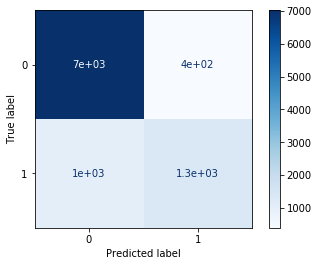

In [187]:
metrics.plot_confusion_matrix(dt_clf, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.show()

## Random forest

In [188]:
rf_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes = 130, random_state=1)
cvs = cross_val_score(rf_clf,X_train,y_train,cv=4)
print(cvs)
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))

[0.85607534 0.86271499 0.86169124 0.85667486]
Accuracy: 0.8593 (+/- 0.0059)


In [189]:
rf_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes = 130, random_state=1)
cvs = cross_val_score(rf_clf,X_train,y_train,cv=4)
print(cvs)
print("Accuracy: %0.4f (+/- %0.4f)" % (cvs.mean(), cvs.std()*2))

[0.85576825 0.86179361 0.86199836 0.85718673]
Accuracy: 0.8592 (+/- 0.0055)


In [190]:
# testing the model with the pruning parameter chosen with CV
rf_clf = RandomForestClassifier(n_estimators=50, max_leaf_nodes = 130, random_state=1)

rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)

print("Accuracy: %0.4f" % metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8543


In [191]:
print("Precision: %0.4f" % metrics.precision_score(y_test, y_pred))
print("Recall:    %0.4f" % metrics.recall_score(y_test, y_pred))
print("AUC:       %0.4f" % metrics.roc_auc_score(y_test, y_pred))
print("F1:        %0.4f" % metrics.f1_score(y_test, y_pred))

Precision: 0.7925
Recall:    0.5375
AUC:       0.7464
F1:        0.6406


In [192]:
rf_metrics = [metrics.accuracy_score(y_test, y_pred), metrics.precision_score(y_test, y_pred),
              metrics.recall_score(y_test, y_pred), metrics.roc_auc_score(y_test, y_pred),
              metrics.f1_score(y_test, y_pred)]

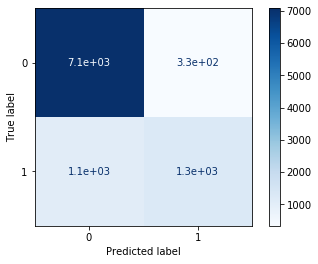

In [193]:
metrics.plot_confusion_matrix(rf_clf, X_test, y_test, cmap=plt.cm.Blues, values_format='d')
plt.show()

## Neural network

In [194]:
# transform label column to the format accepted by 
y_train = tf.one_hot(y_train, depth = 2)

In [195]:
# training a neural network
nn_clf = Sequential()

nn_clf.add(Dense(units = 41, activation = 'relu'))
nn_clf.add(Dense(units = 2 , activation = 'sigmoid'))

nn_clf.compile(optimizer = RMSprop(learning_rate=0.0025), loss = 'binary_crossentropy', metrics = ['accuracy'])

nn_clf.fit(X_train, y_train, epochs = 30)

y_pred = nn_clf.predict(X_test)
rounded_predictions = np.argmax(y_pred, axis=1)
y_pred = (y_pred > 0.5)

Epoch 1/30
1222/1222 [==============================] - 2s 1ms/step - loss: 2.7523 - accuracy: 0.8060
Epoch 2/30
1222/1222 [==============================] - 2s 1ms/step - loss: 1.4629 - accuracy: 0.8238
Epoch 3/30
1222/1222 [==============================] - 2s 1ms/step - loss: 1.2500 - accuracy: 0.8284
Epoch 4/30
1222/1222 [==============================] - 2s 1ms/step - loss: 1.1160 - accuracy: 0.8304
Epoch 5/30
1222/1222 [==============================] - 2s 1ms/step - loss: 1.0734 - accuracy: 0.8317
Epoch 6/30
1222/1222 [==============================] - 2s 2ms/step - loss: 0.9178 - accuracy: 0.8328
Epoch 7/30
1222/1222 [==============================] - 2s 1ms/step - loss: 0.7785 - accuracy: 0.8345
Epoch 8/30
1222/1222 [==============================] - 2s 1ms/step - loss: 0.7650 - accuracy: 0.8343
Epoch 9/30
1222/1222 [==============================] - 2s 1ms/step - loss: 0.7004 - accuracy: 0.8375
Epoch 10/30
1222/1222 [==============================] - 2s 2ms/step - loss: 0.617

In [196]:
print("Accuracy: %0.4f" % metrics.accuracy_score(y_test, rounded_predictions))

Accuracy: 0.8442


In [197]:
print("Precision: %0.4f" % metrics.precision_score(y_test, rounded_predictions))
print("Recall:    %0.4f" % metrics.recall_score(y_test, rounded_predictions))
print("AUC:       %0.4f" % metrics.roc_auc_score(y_test, rounded_predictions))
print("F1:        %0.4f" % metrics.f1_score(y_test, rounded_predictions))

Precision: 0.7119
Recall:    0.5960
AUC:       0.7596
F1:        0.6488


In [198]:
nn_metrics = [metrics.accuracy_score(y_test, rounded_predictions), metrics.precision_score(y_test, rounded_predictions),
              metrics.recall_score(y_test, rounded_predictions), metrics.roc_auc_score(y_test, rounded_predictions),
              metrics.f1_score(y_test, rounded_predictions)]

In [199]:
def plot_cm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], position=(j-0.08, 0.25 + i/2),
#             horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


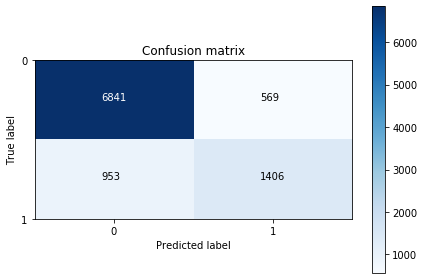

In [200]:
cm = metrics.confusion_matrix(y_true=y_test, y_pred=rounded_predictions)
plot_cm(cm=cm, classes=[0,1], title='Confusion matrix')
plt.show()

## Summary

In [201]:
# Displaying metrics for all 4 models
print("      ACC  Precision Recall   AUC     F1")
print("KNN: %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%" % tuple([100*v for v in knn_metrics]))
print("DT:  %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%" % tuple([100*v for v in dt_metrics]))
print("RF:  %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%" % tuple([100*v for v in rf_metrics]))
print("NN:  %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%   %0.1f%%" % tuple([100*v for v in nn_metrics]))

      ACC  Precision Recall   AUC     F1
KNN: 85.7%   77.8%   57.1%   75.9%   65.9%
DT:  85.5%   77.2%   56.8%   75.7%   65.4%
RF:  85.4%   79.2%   53.8%   74.6%   64.1%
NN:  84.4%   71.2%   59.6%   76.0%   64.9%


The decision tree model has the highest accuracy. The models using $k$ nearest neighbours and random forest were only slightly worse. The neural network might work better with this data with different parameters or network architecture. Random forest model has the highest precision, but has lower recall than KNN and decision tree.